# STEM Optimization Analysis

This notebook demonstrates the basic functionality of the intensity analysis by using the optimization method 

Third-Party Python packages required:

Package "tifffile" for opening the experimental target image

Package "ASE" for importing the initial model


In [1]:
%matplotlib notebook
import os,sys
sys.path.append('/home/christoph/repos/stem_optimization/')
from Model import Model
from Simulation import Simulation
from ase.io import read, write
import matplotlib.pyplot as plt
from tifffile import tifffile
import numpy as np
#import time
import threading
import pickle
from ase.visualize import view
from ase import Atoms

We start by loading the target image, which has to be an atomically resolved STEM image and initializing important parameters for the simulation.

We also start a new thread to plot and update the target image, the simulation, the difference, the PSF and the correlation.


<IPython.core.display.Javascript object>


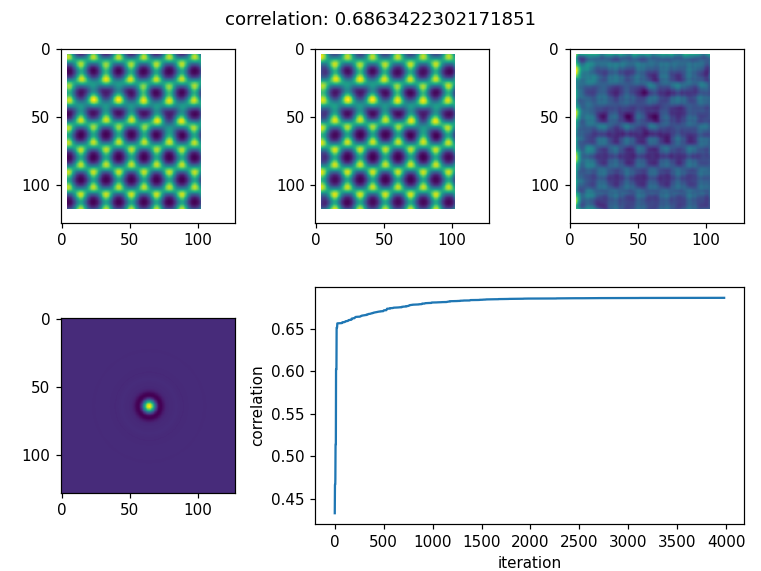

In [18]:
path = '.'
os.chdir(path)
sl = 1 #0...dft, 1... iam, 2...tds
image = tifffile.imread('20_mrad_stack.tif')[sl].T
image[:4] = np.nan
image[118:] = np.nan
image[:,:4] = np.nan
image[:,103:] = np.nan
model = read('monolayer.xyz')
# we assign the W surrounded by three monovacancies a slightly heavier element to distinguish them from the other W atoms
model.numbers[20] = 75
model.numbers[36] = 75

m = Model(model,image, kernelsize=1, start_PlotThread=True,contrast = 0.)

conv_angle = 0.02#rad

energy = 60000 #eV
fov = 2.166#nm

# we do an initial manual  alignment of the target image and the simulation of the model
pixel0  =  [5,4]
atom0 =  0

px = np.max(image.shape)
blur = px/(fov*10)*0.3 ## 0.3 A source size
m.set_up_simulation(conv_angle, energy, fov , blur=blur,atom0 = atom0, pixel0=pixel0 ,method = 'SSB')

plot_thread = threading.Thread(target = m.plotting_thread,args = (m.fig,m.ax), daemon=True)
plot_thread.start()



We now run the optimization, while the plot above constantely updates

Possible parameters: blur, positions, translation, scale, intensities

In [19]:
rounds=10
m.optimize_model(['fov','scale','translation'],iterations = rounds)
m.optimize_model(['fov','scale','translation','intensities','positions','blur'],iterations = rounds)




100%|██████████| 10/10 [01:55<00:00, 11.51s/it]


We can now analyze the atomic intensities. We select the pristine part for the first analysis. 

In [20]:
at = m.ase
sel = (at.get_positions()[:,1]>15)*(at.get_positions()[:,1]<18)*(at.get_positions()[:,0]>6)*(at.get_positions()[:,0]<15)



In [21]:
ints_w = m.intensities[(at.numbers==74)*sel]
ints_s = m.intensities[(at.numbers==16)*sel]



<IPython.core.display.Javascript object>


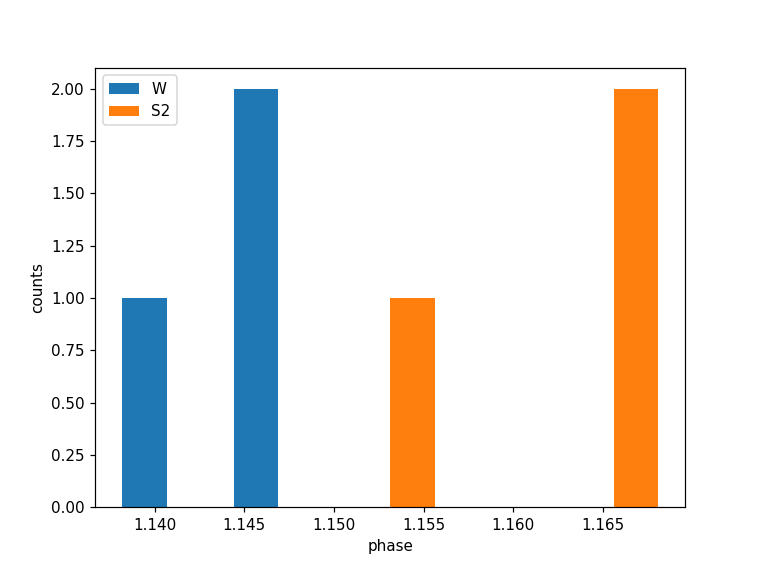

In [22]:
plt.figure()
plt.hist([ints_w,ints_s],color= ['C0','C1'],bins=5,label=['W','S2'])
plt.legend()
plt.ylabel('counts')
plt.xlabel('phase')
plt.show()

The S2/W ratio should be >1 for IAM and <1 for DFT and the TDS

In [23]:
(np.mean(ints_s)/np.mean(ints_w))

1.0170875781026012

In [24]:
at = m.ase
sel = (at.get_positions()[:,1]>5)*(at.get_positions()[:,1]<15)*(at.get_positions()[:,0]>5)*(at.get_positions()[:,0]<15)
ints_w = m.intensities[(at.numbers==74)*sel]#/np.mean(m.intensities[sel])
ints_w2 = m.intensities[(at.numbers==75)*sel]#/np.mean(m.intensities[sel])

ints_s = m.intensities[(at.numbers==16)*sel]#/np.mean(m.intensities[sel])

<IPython.core.display.Javascript object>


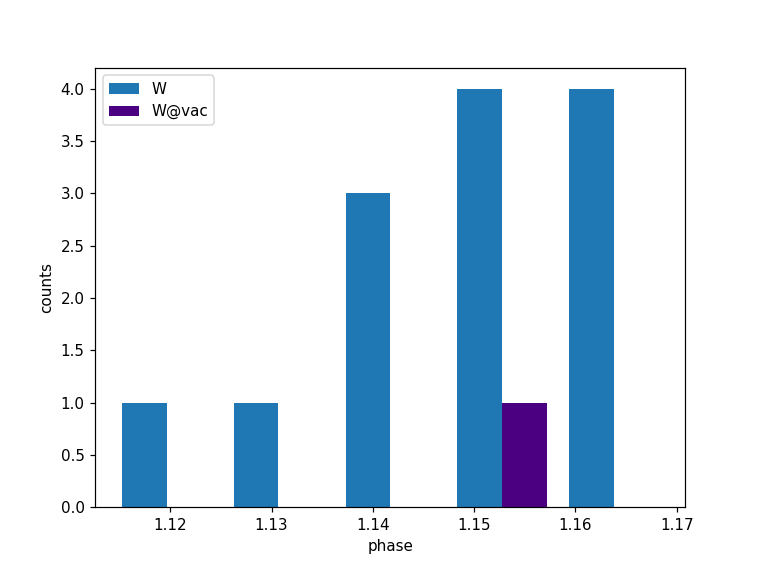

In [25]:
plt.figure()
plt.hist([ints_w,ints_w2],color= ['C0','indigo'],bins=5,label=['W','W@vac'])
plt.legend()
plt.ylabel('counts')
plt.xlabel('phase')
plt.show()